
# ViEWS 3 ensembles: future predictions
ViEWS monthly updates, cm level
Fatalities002 version

This notebook produces future predictions for a set of models defined in the list of dictionaries ModelList and the weights stored as iweights_df.csv. Both of these are produced by the notebook fatal_cm_compute_ensemble in this repository. 

The notebook draws on the following .py script files in this repository:

Ensembling.py

FetchData.py

ViewsEstimators.py

It also requires the list of models included in the ensemble, in the following file:

ModelDefinitions.py

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
# sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Views 3
from viewser.operations import fetch
from viewser import Queryset, Column
import views_runs
from views_partitioning import data_partitioner, legacy
from stepshift import views
from views_runs import storage, ModelMetadata
from views_runs.storage import store, retrieve, fetch_metadata
from views_forecasts.extensions import *
import views_mapper2
from views_mapper2.mapper2 import Mapper2
from views_mapper2 import color
from views_mapper2.label_writer import vid2date
from views_mapper2.dictionary_writer import standard_scale

# Mapper
import geopandas as gpd

import sqlalchemy as sa
#from ingester3.config import source_db_path

# Other packages
import pickle as pkl

#Parallelization
from joblib import Parallel, delayed, cpu_count
from functools import partial

from pathlib import Path

# Packages from this repository, Tools folder
import sys
sys.path.append('../')
sys.path.append('../Tools')
sys.path.append('../Intermediates')
sys.path.append('../SystemUpdates')
import os
from pathlib import Path

from Ensembling import CalibratePredictions, RetrieveStoredPredictions, mean_sd_calibrated, gam_calibrated

from FetchData import FetchData, RetrieveFromList, ReturnQsList, get_df_from_datasets_by_name
from ViewsEstimators import *

Refreshing


In [3]:
# Common parameters:

dev_id = 'Fatalities002'
run_id = dev_id 
EndOfHistory = 518
prod_id = '2022_04_t01'
RunGeneticAlgo = False
level = 'cm'
WriteToOverleaf = False
get_future = False

username = os.getlogin()

steps = [*range(1, 36+1, 1)] # Which steps to train and predict for

#steps = [1,2,3,4,5,6,7,8,9,10,11,12,15,18,21,24] # Which steps to train and predict for
#fi_steps = [1,3,6,12,36] # Which steps to present feature importances for
#steps = [1,12,24,36]
fi_steps = [1,3,6,12,36]
#steps = [1,6,36]
#fi_steps = [1,6,36]

# Specifying partitions

calib_partitioner_dict = {"train":(121,408),"predict":(409,456)}
test_partitioner_dict = {"train":(121,456),"predict":(457,504)}
future_partitioner_dict = {"train":(121,504),"predict":(505,516)}
calib_partitioner =  views_runs.DataPartitioner({"calib":calib_partitioner_dict})
test_partitioner =  views_runs.DataPartitioner({"test":test_partitioner_dict})
future_partitioner =  views_runs.DataPartitioner({"future":future_partitioner_dict})

# Specifying paths - note these have to be set to conform to individual setups!

Mydropbox = f'/Users/{username}/Dropbox (ViEWS)/ViEWS/'
localgitpath = f'/Users/{username}/Desktop/VIEWS_new/'
notebookpath = os.getcwd()
markovpath = str(Path(notebookpath).parent.absolute())+'/Tools/markov/'

if WriteToOverleaf:
    if EndOfHistory==508:
        overleafpath = f'/Users/{username}/Dropbox (ViEWS)/Apps/Overleaf/ViEWS_Presentations_2021/Figures/Forecasts/Apr2022/'
    if EndOfHistory==509:
        overleafpath = f'/Users/{username}/Dropbox (ViEWS)/Apps/Overleaf/ViEWS_Presentations_2021/Figures/Forecasts/Apr2022/'
    
    print('Overleaf path set to',overleafpath)

print('Dropbox path set to:',Mydropbox)
print('Local GIT Path:', localgitpath)
print('Markov code path set to:',markovpath)


Dropbox path set to: /Users/jim/Dropbox (ViEWS)/ViEWS/
Local GIT Path: /Users/jim/Desktop/VIEWS_new/
Markov code path set to: /Users/jim/Work/ViEWS/ViEWS3/viewsforecasting/Tools/markov/


# Retrieve models and predictions

In [4]:
from ModelDefinitions import DefineEnsembleModels

ModelList = DefineEnsembleModels(level)
    
i = 0
for model in ModelList:
    print(i, model['modelname'], model['data_train'])
    i = i + 1

0 fatalities002_baseline_rf baseline002
1 fatalities002_conflicthistory_rf conflict_ln
2 fatalities002_conflicthistory_gbm conflict_ln
3 fatalities002_conflicthistory_hurdle_lgb conflict_ln
4 fatalities002_conflicthistory_long_xgb conflictlong_ln
5 fatalities002_vdem_hurdle_xgb vdem_short
6 fatalities002_wdi_rf wdi_short
7 fatalities002_topics_rf topics_002
8 fatalities002_topics_xgb topics_002
9 fatalities002_topics_hurdle_lgb topics_002
10 fatalities002_joint_broad_rf joint_broad
11 fatalities002_joint_broad_hurdle_rf joint_broad
12 fatalities002_joint_narrow_xgb joint_narrow
13 fatalities002_joint_narrow_hurdle_xgb joint_narrow
14 fatalities002_joint_narrow_hurdle_lgb joint_narrow
15 fatalities002_all_pca3_xgb all_features
16 fatalities002_aquastat_rf aquastat
17 fatalities002_faostat_rf faostat
18 fatalities002_faoprices_rf faoprices
19 fatalities002_imfweo_rf imfweo
20 fatalities002_Markov_glm joint_narrow
21 fatalities002_Markov_rf joint_narrow


# Retrieve and calibrate predictions and data

In [ ]:
### Running and saving David's models
## Import subprocess to run Rscript
#import subprocess

## Fetch and save data (can perhaps be simplified?)
#qs = Queryset('hh_20_features','country_month')
#qs.fetch().to_parquet(markovpath + 'tmp.parquet')

## Set commands and arguments. R-scripts located in 'Markov'-folder
#command ='Rscript'
##path2script ='../Tools/markov/omm_ranger_hh20_fcdo_py.R'
#path2script = markovpath + 'omm_ranger_hh20_fcdo_py.R'

#cmd = [command, path2script]
#data_path = markovpath + 'tmp.parquet'
#save_path = Mydropbox + 'Projects/PredictingFatalities/Predictions/cm/preds/'
#args = [str(EndOfHistory),data_path,save_path,]

## Run subprocess. Saves the predictions as csv-files to the save_path location with prefix vmm_[estimator]_hh20_[EndOfHistory]
#subprocess.call(cmd+args)


In [ ]:
## Retrieve David's models from dropbox and store in prediction storage
#path = Mydropbox + 'Projects/PredictingFatalities/Predictions/cm/preds/'

#DRList = [
#    {
#        'modelname': 'fat_hh20_Markov_glm',
#        'filename': path + 'vmm_glm_hh20_' + str(EndOfHistory) + '.csv'
#    },
    
#    {
#        'modelname': 'fat_hh20_Markov_rf',
#        'filename': path + 'vmm_rf_hh20_' + str(EndOfHistory) + '.csv'
#    }
#]
    
#for model in DRList:
#    df_future = pd.read_csv(model['filename'],index_col=['month_id','country_id'])
#    df_future['ln_ged_sb_dep'] = np.nan # Empty dependent variable column for consistency/required by prediction storage function
#    stored_modelname = level + '_' + model['modelname'] + '_f' + str(EndOfHistory)
#    df_future.forecasts.set_run(dev_id)
#    df_future.forecasts.to_store(name=stored_modelname, overwrite=True)    

In [5]:
# Retrieving the predictions for calibration and test partitions
# The ModelList contains the predictions organized by model

ModelList = RetrieveStoredPredictions(ModelList, steps, EndOfHistory, dev_id, level, get_future)

ModelList = CalibratePredictions(ModelList, EndOfHistory, steps)

0 fatalities002_baseline_rf
pr_46_cm_fatalities002_baseline_rf_calib.parquet
pr_46_cm_fatalities002_baseline_rf_test.parquet
1 fatalities002_conflicthistory_rf
pr_46_cm_fatalities002_conflicthistory_rf_calib.parquet
pr_46_cm_fatalities002_conflicthistory_rf_test.parquet
2 fatalities002_conflicthistory_gbm
pr_46_cm_fatalities002_conflicthistory_gbm_calib.parquet
pr_46_cm_fatalities002_conflicthistory_gbm_test.parquet
3 fatalities002_conflicthistory_hurdle_lgb
pr_46_cm_fatalities002_conflicthistory_hurdle_lgb_calib.parquet
pr_46_cm_fatalities002_conflicthistory_hurdle_lgb_test.parquet
4 fatalities002_conflicthistory_long_xgb
pr_46_cm_fatalities002_conflicthistory_long_xgb_calib.parquet
pr_46_cm_fatalities002_conflicthistory_long_xgb_test.parquet
5 fatalities002_vdem_hurdle_xgb
pr_46_cm_fatalities002_vdem_hurdle_xgb_calib.parquet
pr_46_cm_fatalities002_vdem_hurdle_xgb_test.parquet
6 fatalities002_wdi_rf
pr_46_cm_fatalities002_wdi_rf_calib.parquet
pr_46_cm_fatalities002_wdi_rf_test.parquet

In [6]:
# Run querysets and postprocessing (e.g. PCA) to obtain data for future prediction
qslist = ReturnQsList(level)
from FetchData import fetch_cm_data_from_model_def

Datasets=fetch_cm_data_from_model_def(qslist,EndOfHistory)

 .    fatalities002_baseline; A dataset with 6 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_topics_stub; A dataset with 64 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_aquastat_stub; A dataset with 11 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_cm_conflict_history_stub; A dataset with 24 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_cm_conflict_history_ext; A dataset with 33 columns, with data between t = 1 and 852. (213 units)
 .    fatalities002_vdem_short_stub; A dataset with 58 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_wdi_short_stub; A dataset with 28 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_joint_narrow; A dataset with 41 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_joint_broad_stub; A dataset with 77 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_faostat_stub;A 

In [7]:
# EndOfHistory can be reset here to facilitate rerunning several months without rereading input data
# Remove '#' and reset
#EndOfHistory = 506

In [8]:
for ds in Datasets:
    df = ds['df']
    print(ds['Name'],df.isna().sum())
    ds['df']=df.fillna(0)

wdi_short ln_ged_sb_dep                      0
ln_ged_sb                          0
wdi_sp_pop_totl                 2242
wdi_ag_lnd_frst_k2              2620
wdi_dt_oda_odat_pc_zs          29607
wdi_ms_mil_xpnd_gd_zs          24108
wdi_ms_mil_xpnd_zs             28621
wdi_nv_agr_totl_kd              6597
wdi_nv_agr_totl_kn              5053
wdi_ny_gdp_pcap_kd              4071
wdi_sp_dyn_le00_in              3094
wdi_se_enr_prim_fm_zs           3448
wdi_se_enr_prsc_fm_zs           5152
wdi_se_prm_nenr                 6365
wdi_sh_sta_maln_zs             30885
wdi_sh_sta_stnt_zs             30885
wdi_sl_tlf_totl_fe_zs          11586
wdi_sm_pop_refg_or              4664
wdi_sm_pop_netm                 2242
wdi_sm_pop_totl_zs              2641
wdi_sp_dyn_imrt_in              2242
wdi_sh_dyn_mort_fe              2242
wdi_sp_pop_14_fe_zs             2242
wdi_sp_pop_1564_fe_zs           2242
wdi_sp_pop_65up_fe_zs           2242
wdi_sp_pop_grow                 2242
wdi_sp_urb_totl_in_zs       

Length: 191, dtype: int64
joint_broad gleditsch_ward                     0
ln_ged_sb_dep                      0
ln_ged_sb                          0
ln_ged_ns                          0
ln_ged_os                          0
                                  ..
_splag_1_decay_ged_sb_5            0
splag_1_decay_ged_os_5             0
splag_1_decay_ged_ns_5             0
topic_ste_theta4_stock_t1_splag    0
topic_ste_theta5_stock_t1_splag    0
Length: 83, dtype: int64
aquastat ln_ged_sb_dep                     0
ln_ged_sb                         0
wdi_sp_pop_totl                2242
agr_withdrawal_pct_t48           32
dam_cap_pcap_t48                 32
groundwater_export_t48           32
fresh_withdrawal_pct_t48         32
ind_efficiency_t48               32
irr_agr_efficiency_t48           32
services_efficiency_t48          32
general_efficiency_t48           32
water_stress_t48                 32
renewable_internal_pcap_t48      32
renewable_pcap_t48               32
decay_ged_sb_5   

In [9]:
for ds in Datasets:
    df = ds['df']
    print(ds['Name'],df.isna().sum())

wdi_short ln_ged_sb_dep                  0
ln_ged_sb                      0
wdi_sp_pop_totl                0
wdi_ag_lnd_frst_k2             0
wdi_dt_oda_odat_pc_zs          0
wdi_ms_mil_xpnd_gd_zs          0
wdi_ms_mil_xpnd_zs             0
wdi_nv_agr_totl_kd             0
wdi_nv_agr_totl_kn             0
wdi_ny_gdp_pcap_kd             0
wdi_sp_dyn_le00_in             0
wdi_se_enr_prim_fm_zs          0
wdi_se_enr_prsc_fm_zs          0
wdi_se_prm_nenr                0
wdi_sh_sta_maln_zs             0
wdi_sh_sta_stnt_zs             0
wdi_sl_tlf_totl_fe_zs          0
wdi_sm_pop_refg_or             0
wdi_sm_pop_netm                0
wdi_sm_pop_totl_zs             0
wdi_sp_dyn_imrt_in             0
wdi_sh_dyn_mort_fe             0
wdi_sp_pop_14_fe_zs            0
wdi_sp_pop_1564_fe_zs          0
wdi_sp_pop_65up_fe_zs          0
wdi_sp_pop_grow                0
wdi_sp_urb_totl_in_zs          0
splag_wdi_sl_tlf_totl_fe_zs    0
splag_wdi_sm_pop_refg_or       0
splag_wdi_sm_pop_netm          0


Length: 83, dtype: int64
aquastat ln_ged_sb_dep                  0
ln_ged_sb                      0
wdi_sp_pop_totl                0
agr_withdrawal_pct_t48         0
dam_cap_pcap_t48               0
groundwater_export_t48         0
fresh_withdrawal_pct_t48       0
ind_efficiency_t48             0
irr_agr_efficiency_t48         0
services_efficiency_t48        0
general_efficiency_t48         0
water_stress_t48               0
renewable_internal_pcap_t48    0
renewable_pcap_t48             0
decay_ged_sb_5                 0
decay_ged_os_5                 0
splag_1_decay_ged_sb_5         0
dtype: int64
pca_all ln_ged_sb_dep             0
ln_ged_sb                 0
decay_ged_sb_5            0
decay_ged_os_5            0
splag_1_decay_ged_sb_5    0
wdi_sp_pop_totl           0
pc1                       0
pc2                       0
pc3                       0
pc4                       0
pc5                       0
pc6                       0
pc7                       0
pc8                 

In [10]:
from views_runs import Storage, StepshiftedModels
from views_partitioning.data_partitioner import DataPartitioner
from viewser import Queryset, Column
from views_runs import operations
from views_runs.run_result import RunResult
from new_markov import markov
from pygam import LogisticGAM, LinearGAM, s, te

RewritePredictions = True # Set this to True to rewrite predictions even if they exist

force_retrain = False

def RetrainAndPredict(modelname):

    modelstore = storage.Storage()
    # Predictions for true future
    ct = datetime.now()
    print('Future', ct)
    modelstore = storage.Storage()
    model['RunResult_future']  = RunResult.retrain_or_retrieve(
            retrain            = force_retrain,
            store              = modelstore,
            partitioner        = DataPartitioner({"test":future_partitioner_dict}),
            stepshifted_models = StepshiftedModels(model['algorithm'], steps, model['depvar']),
            dataset            = RetrieveFromList(Datasets,model['data_train']),
            queryset_name      = model['queryset'],
            partition_name     = "test",
            timespan_name      = "train",
            storage_name       = model['modelname'] + '_future',
            author_name        = "HH",
    )       
    predictions_future = model['RunResult_future'].run.future_point_predict(EndOfHistory,model['RunResult_future'].data)
    return predictions_future



i = 0
print('Computing predictions, production run ' + prod_id + ', development run ' + dev_id)
for model in ModelList[:]:

    # Loop that checks whether (1) this a model trained outside the main system, 
    # (2) retrieves the prediction if it exists in prediction storage,
    # (3) if not checks whether the trained model exists, retrains if not, 
    # Then calibrates the predictions and stores them if they have not been stored before for this run.
    # To do: set the data_preprocessing to the function in the model dictionary
    
    model['predstorename_ncal'] = level +  '_' + model['modelname'] + '_noncalibrated' + '_f' + str(EndOfHistory)
    model['predstorename_cal'] = level +  '_' + model['modelname'] + '_calibrated' + '_f' + str(EndOfHistory)

    
    if 'Markov' not in model['modelname']: # Only Markov models are currently exceptions
        print(i, model['modelname'])

        ct = datetime.now()
        print('Trying to retrieve non-calibrated predictions', ct)
        if RewritePredictions:
            model['future_df_noncalibrated'] = RetrainAndPredict(model['predstorename_ncal'])
        else:
            try:
                model['future_df_noncalibrated'] = pd.DataFrame.forecasts.read_store(run=run_id, name=model['predstorename_ncal'])
                print('Predictions for ', model['predstorename_ncal'], ', run', run_id, 'exist, retrieving from prediction storage')

            except KeyError:
                print(model['predstorename_ncal'], ', run', run_id, 'does not exist, predicting')
                model['future_df_noncalibrated'] = RetrainAndPredict(model['predstorename_ncal'])

        # Calibrating and storing   
        # Storing non-calibrated
        
        model['future_df_noncalibrated'].forecasts.set_run(run_id)
        model['future_df_noncalibrated'].forecasts.to_store(name=model['predstorename_ncal'], overwrite=True)   
        print('Calibrating')
        model['future_df_calibrated'] = model['future_df_noncalibrated'].copy()
        for step in steps:
            thismonth = EndOfHistory + step
            
            model['future_df_calibrated'].loc[thismonth,'step_combined'] = pd.DataFrame(model['calibration_gams'][step-1]['calibration_GAM'].predict(model['future_df_noncalibrated'].loc[thismonth])).values
         # Storing calibrated
        model['future_df_calibrated'].forecasts.set_run(run_id)
        model['future_df_calibrated'].forecasts.to_store(name=model['predstorename_cal'], overwrite=True)   
            
    else: # If one of David's Markov models
        print(i, model['modelname'])
            
        ct = datetime.now()
        print('Trying to retrieve non-calibrated predictions', ct)
        if RewritePredictions:
            model['future_df_noncalibrated'] = markov.compute_markov(test_partitioner_dict, EndOfHistory, model['depvar'], 'future', model['algorithm'])
        else:
            try:
                model['future_df_noncalibrated'] = pd.DataFrame.forecasts.read_store(run=run_id, name=model['predstorename_ncal'])
                print('Predictions for ', model['predstorename_ncal'], ', run', run_id, 'exist, retrieving from prediction storage')

            except KeyError:
                print(model['predstorename_ncal'], ', run', run_id, 'does not exist, predicting')
                model['future_df_noncalibrated'] = markov.compute_markov(test_partitioner_dict, EndOfHistory, model['depvar'], 'future', model['algorithm']) 
            
            
        model['future_df_noncalibrated'].forecasts.set_run(run_id)
        model['future_df_noncalibrated'].forecasts.to_store(name=model['predstorename_ncal'], overwrite=True) 
            
        model['future_df_calibrated'] = model['future_df_noncalibrated'].copy()
        
        model['future_df_calibrated']['step_combined']=pd.DataFrame(model['future_df_noncalibrated']['weighted_prediction'])
         # Storing calibrated
        
        model['future_df_calibrated'].forecasts.set_run(run_id)
        model['future_df_calibrated'].forecasts.to_store(name=model['predstorename_cal'], overwrite=True)   


    i = i + 1

print('All done')

Computing predictions, production run 2022_04_t01, development run Fatalities002
0 fatalities002_baseline_rf
Trying to retrieve non-calibrated predictions 2023-04-13 10:09:35.520220
Future 2023-04-13 10:09:35.531903
 * == Performing a run: "fatalities002_baseline_rf_future" == * 
Model object named "fatalities002_baseline_rf_future" with equivalent metadata already exists.
Fetching "fatalities002_baseline_rf_future" from storage
Calibrating
1 fatalities002_conflicthistory_rf
Trying to retrieve non-calibrated predictions 2023-04-13 10:09:54.474391
Future 2023-04-13 10:09:54.487858
 * == Performing a run: "fatalities002_conflicthistory_rf_future" == * 
Model object named "fatalities002_conflicthistory_rf_future" with equivalent metadata already exists.
Fetching "fatalities002_conflicthistory_rf_future" from storage
Calibrating
2 fatalities002_conflicthistory_gbm
Trying to retrieve non-calibrated predictions 2023-04-13 10:10:12.800629
Future 2023-04-13 10:10:12.812583
 * == Performing a r

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘arrow’

The following object is masked from ‘package:magrittr’:

    is_in

The following object is masked from ‘package:utils’:

    timestamp




 All required packages installed 

 Packages loaded, starting script 


There were 50 or more warnings (use warnings() to see the first 50)



 Rscript finished! 
21 fatalities002_Markov_rf
Trying to retrieve non-calibrated predictions 2023-04-13 10:24:10.143061
 .    

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘arrow’

The following object is masked from ‘package:magrittr’:

    is_in

The following object is masked from ‘package:utils’:

    timestamp




 All required packages installed 

 Packages loaded, starting script 


There were 50 or more warnings (use warnings() to see the first 50)



 Rscript finished! 
All done


In [11]:
EnsembleList = [] # Separate list of dictionaries for ensembles!

Ensemble = {
    'modelname':            'genetic_ensemble',
    'algorithm':            [],
    'depvar':               'ln_ged_sb_dep',
    'data_train':           [],
    'Algorithm_text':       '',
    'calibration_gams':     [],
    'future_df_calibrated': [],
}
EnsembleList.append(Ensemble)


In [12]:
# Collecting in one df, one column per model
ConstituentModels_df = pd.DataFrame(ModelList[0]['future_df_calibrated']['step_combined'])
ConstituentModels_df.columns = [ModelList[0]['modelname']]
for model in ModelList[:]:
    print(model['modelname'])
    ConstituentModels_df[model['modelname']] = pd.DataFrame(model['future_df_calibrated']['step_combined'])


fatalities002_baseline_rf
fatalities002_conflicthistory_rf
fatalities002_conflicthistory_gbm
fatalities002_conflicthistory_hurdle_lgb
fatalities002_conflicthistory_long_xgb
fatalities002_vdem_hurdle_xgb
fatalities002_wdi_rf
fatalities002_topics_rf
fatalities002_topics_xgb
fatalities002_topics_hurdle_lgb
fatalities002_joint_broad_rf
fatalities002_joint_broad_hurdle_rf
fatalities002_joint_narrow_xgb
fatalities002_joint_narrow_hurdle_xgb
fatalities002_joint_narrow_hurdle_lgb
fatalities002_all_pca3_xgb
fatalities002_aquastat_rf
fatalities002_faostat_rf
fatalities002_faoprices_rf
fatalities002_imfweo_rf
fatalities002_Markov_glm
fatalities002_Markov_rf


In [13]:
# Retrieve genetic algorithm results
i_weights_df = pd.read_csv('../Intermediates/GeneticWeights.csv')

# Retrieve ensemble predictions for test partition to create categorical predictions

In [14]:
stored_modelname_test = level + '_' + 'ensemble_genetic' + '_test'

ensemble_test_df = pd.DataFrame.forecasts.read_store(stored_modelname_test, run=run_id)
ensemble_test_df.replace([np.inf, -np.inf], 0, inplace=True)  

ensemble_test_df

pr_46_cm_ensemble_genetic_test.parquet


ln_ged_sb_dep  step_pred_1  step_pred_2  step_pred_3  \
month_id country_id                                                         
457      1                0.000000     0.001978     0.003497     0.011178   
         2                0.000000     0.002530     0.004564     0.005590   
         3                0.000000     0.000944     0.001304    -0.000167   
         4                0.000000     0.020728     0.039397     0.045162   
         5                0.000000     0.009106     0.005935     0.012618   
...                            ...          ...          ...          ...   
504      242              2.079442     0.995926     0.705604     0.880018   
         243              0.000000     0.724144     0.127998     0.161672   
         244              0.000000     0.015619     0.019888     0.035300   
         245              0.000000     1.408738     1.360833     1.316864   
         246              4.127134     1.346794     1.660093     1.971379   

                     step_pred_4  step_pred_5  step_pred_6  step_pred_7  \
month_id country_id                                                       
457      1              0.004701     0.006264     0.008189     0.015482   
         2              0.004629     0.004879     0.005810     0.020346   
         3              0.001198     0.001485     0.003458     0.012630   
         4              0.057385     0.071279     0.094698     0.139627   
         5              0.007583     0.009034     0.009017     0.021904   
...                          ...          ...          ...          ...   
504      242            0.999895     0.393566     0.374821     0.375873   
         243            0.083070     0.161759     0.507011     0.529590   
         244            0.035670     0.034737     0.040122     0.044440   
         245            1.818693     1.853320     1.403070     1.696858   
         246            2.147865     1.974485     1.920206     1.643206   

                     step_pred_8  step_pred_9  ...  step_pred_27  \
month_id country_id                            ...                 
457      1              0.030700     0.052553  ...      0.099815   
         2              0.025967     0.049559  ...      0.044940   
         3              0.010502     0.013761  ...      0.040503   
         4              0.095428     0.084397  ...      0.194528   
         5              0.028739     0.042984  ...      0.037420   
...                          ...          ...  ...           ...   
504      242            0.488246     0.584543  ...      0.194190   
         243            0.690084     0.090913  ...      0.079091   
         244            0.076220     0.080627  ...      0.214332   
         245            1.950107     2.169691  ...      2.373206   
         246            1.431764     1.597915  ...      2.396901   

                     step_pred_28  step_pred_29  step_pred_30  step_pred_31  \
month_id country_id                                                           
457      1               0.112974      0.068193      0.082165      0.082842   
         2               0.048418      0.047638      0.053273      0.058376   
         3               0.041860      0.041693      0.046048      0.049641   
         4               0.172190      0.178122      0.140394      0.182322   
         5               0.037189      0.039010      0.049002      0.051931   
...                           ...           ...           ...           ...   
504      242             0.253201      0.261359      0.212026      0.226047   
         243             0.085876      0.167289      0.190547      0.081083   
         244             0.225872      0.219786      0.250110      0.257610   
         245             2.266509      2.720963      2.872006      3.126369   
         246             2.327254      2.354693      2.184305      2.534972   

                     step_pred_32  step_pred_33  step_pred_34  step_pred_35  \
month_id country_id                                

In [15]:
# Generate dichotomous version of dependent variable
ensemble_test_df['ged_gte_25'] = ensemble_test_df['ln_ged_sb_dep'].apply(lambda x: 1 if x >= np.log1p(25) else 0)
# Generate multiclass version for uncertainty estimation
def ged_categorical(x):
    if x < np.log1p(0.5):
        return 0
    elif x < np.log1p(10):
        return 1
    elif x < np.log1p(100):
        return 2
    elif x < np.log1p(1000):
        return 3
    else :
        return 4

ensemble_test_df['ged_multi'] = ensemble_test_df['ln_ged_sb_dep'].apply(ged_categorical)

ensemble_test_df.describe()

,ln_ged_sb_dep,step_pred_1,step_pred_2,step_pred_3,step_pred_4,step_pred_5,step_pred_6,step_pred_7,step_pred_8,step_pred_9,...,step_pred_29,step_pred_30,step_pred_31,step_pred_32,step_pred_33,step_pred_34,step_pred_35,step_pred_36,ged_gte_25,ged_multi
count,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,...,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000
mean,0.514870,0.576759,0.585654,0.606859,0.615250,0.613528,0.631147,0.635804,0.632029,0.642654,...,0.692426,0.702693,0.718017,0.715669,0.727690,0.715149,0.729981,0.721715,0.078861,0.300393
std,1.379484,1.433845,1.418202,1.429012,1.452556,1.435357,1.471482,1.441414,1.406499,1.416383,...,1.372366,1.392882,1.422345,1.418045,1.438122,1.401232,1.437787,1.409440,0.269537,0.769830
min,0.000000,-0.001334,-0.003475,-0.002508,-0.010070,-0.004921,-0.003107,0.003737,0.004968,0.009514,...,0.029862,0.032167,0.036204,0.038281,0.041565,0.042800,0.044600,0.046995,0.000000,0.000000
25%,0.000000,0.002934,0.004096,0.008454,0.005165,0.006743,0.007474,0.016258,0.025275,0.040627,...,0.044803,0.049578,0.052124,0.053857,0.056716,0.059165,0.061375,0.064885,0.000000,0.000000
50%,0.000000,0.009009,0.009266,0.018927,0.011710,0.017348,0.017673,0.026934,0.046951,0.052687,...,0.081001,0.081445,0.086624,0.088085,0.093243,0.092723,0.093060,0.100003,0.000000,0.000000
75%,0.000000,0.114522,0.128181,0.204952,0.158136,0.192655,0.251288,0.264300,0.262859,0.267017,...,0.380296,0.379863,0.379350,0.380295,0.390278,0.402620,0.416498,0.405620,0.000000,0.000000
max,9.327857,9.931419,8.909577,9.029296,8.493330,8.234144,8.835261,8.151808,8.783080,8.369587,...,8.307505,8.246951,8.410224,8.797825,9.047364,8.800444,9.436468,9.513861,1.000000,4.000000


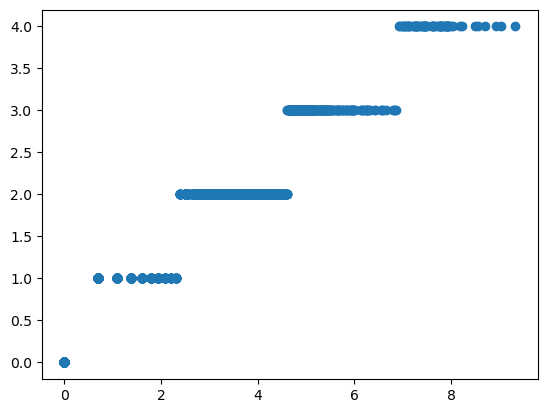

In [16]:
plt.scatter(ensemble_test_df['ln_ged_sb_dep'],ensemble_test_df['ged_multi'])

In [17]:
# Train model to transform predictions from  fatalities to (1) dichotomous and (2) multiclass
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
dichotomous_classifiers = []
multi_classifiers = []
for step in steps:
    X = np.array(ensemble_test_df[f'step_pred_{step}'])
    X = X.reshape(-1,1)
    # Dichotomous
    y_dich = np.array(ensemble_test_df['ged_gte_25']).reshape(-1, 1)
    dich_clf = LogisticRegression(random_state=0).fit(X, y_dich)
    p_dich = dich_clf.predict_proba(X)
    ensemble_test_df[f'dich_step_{step}_logit'] = p_dich[:,1].ravel()
    # Calibrated
    calibrated_dich_clf = CalibratedClassifierCV(base_estimator=dich_clf, cv=3)
    calibrated_dich_clf.fit(X, y_dich)
    p_dich_cal = calibrated_dich_clf.predict_proba(X)
    dichotomous_classifiers.append(calibrated_dich_clf)
    ensemble_test_df[f'dich_cal_step_{step}_logit'] = p_dich_cal[:,1].ravel()
    # Multiclass
    y_multi = np.array(ensemble_test_df['ged_multi']).reshape(-1, 1)
    multi_clf = LogisticRegression(random_state=0).fit(X, y_multi)
    multi_classifiers.append(multi_clf)
    p_multi = multi_clf.predict_proba(X)
    for cls in [0,1,2,3,4]:
        ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()

ensemble_test_df[['dich_step_3_logit','dich_cal_step_3_logit']].describe()

,dich_step_3_logit,dich_cal_step_3_logit
count,9168.000000,9168.000000
mean,0.078861,0.078893
std,0.229732,0.228815
min,0.003809,0.004070
25%,0.003880,0.004144
50%,0.003948,0.004215
75%,0.005379,0.005716
max,0.999927,0.999915


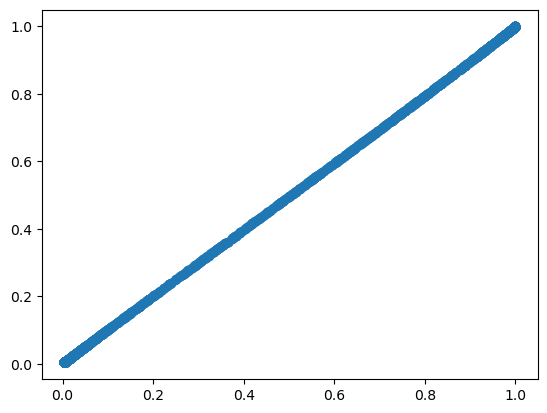

In [18]:
plt.scatter(ensemble_test_df['dich_step_3_logit'],ensemble_test_df['dich_cal_step_3_logit'])

# Calculating and storing ensemble future predictions

In [19]:
# Setting up a placeholder df for ensemble predictions
EnsembleList[0]['future_df_calibrated'] = ModelList[0]['future_df_calibrated'].copy() # Copy from baseline
EnsembleList[0]['future_df_dichotomous'] = ModelList[0]['future_df_calibrated'].copy() # Copy from baseline

df=EnsembleList[0]['future_df_calibrated'].fillna(0)
EnsembleList[0]['future_df_calibrated']=df
df=EnsembleList[0]['future_df_dichotomous'].fillna(0)
EnsembleList[0]['future_df_dichotomous']=df


ConstituentModels_df_w = ConstituentModels_df.copy().fillna(0)

for step in steps:
    month = EndOfHistory + step
    weightcol = 'step_pred_' + str(step)
    weights = np.array(pd.DataFrame(i_weights_df[weightcol]))
    EnsembleList[0]['future_df_calibrated'].loc[month] = ConstituentModels_df_w.loc[month].dot(weights).values
    x_d = np.array(EnsembleList[0]['future_df_calibrated'].loc[month]).reshape(-1,1)
    pred_step = dichotomous_classifiers[step-1].predict_proba(x_d)
    EnsembleList[0]['future_df_dichotomous']['step_combined'].loc[month] = pred_step[:,1]

In [20]:
# Storing the ensemble future predictions
predstore_future = level +  '_' + EnsembleList[0]['modelname'] + '_f' + str(EndOfHistory)
EnsembleList[0]['future_df_calibrated'].forecasts.set_run(run_id)
EnsembleList[0]['future_df_calibrated'].forecasts.to_store(name=predstore_future, overwrite = True) 
predstore_future_dich = level +  '_' + EnsembleList[0]['modelname'] + '_dich_f' + str(EndOfHistory)
EnsembleList[0]['future_df_dichotomous'].forecasts.set_run(run_id)
EnsembleList[0]['future_df_dichotomous'].forecasts.to_store(name=predstore_future_dich, overwrite = True) 


In [21]:
ViewsMetadata().with_name('genetic').fetch()

,id,name,file_name,runs_id,model_generations_id,user_name,spatial_loa,temporal_loa,ds,osa,time_min,time_max,space_min,space_max,steps,target,prediction_columns,date_written,description,deleted
0,1137,cm_ensemble_genetic_f505,pr_33_cm_ensemble_genetic_f505.parquet,33,1,hh,c,m,False,False,506,541,1,246,[],step_combined,[],2022-03-19 08:09:49.362072+00:00,None,False
1,12013,cm_ensemble_genetic_exp_exp_calib,pr_33_cm_ensemble_genetic_exp_exp_calib.parquet,33,1,hh,c,m,False,True,397,444,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-26 10:21:27.861484+00:00,None,False
2,12014,cm_ensemble_genetic_exp_exp_test,pr_33_cm_ensemble_genetic_exp_exp_test.parquet,33,1,hh,c,m,False,True,445,492,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-26 10:21:34.024314+00:00,None,False
3,12017,cm_ensemble_genetic_exp_calib,pr_33_cm_ensemble_genetic_exp_calib.parquet,33,1,hh,c,m,False,True,397,444,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-26 10:40:57.763694+00:00,None,False
4,12018,cm_ensemble_genetic_exp_test,pr_33_cm_ensemble_genetic_exp_test.parquet,33,1,hh,c,m,False,True,445,492,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-26 10:41:06.365460+00:00,None,False
5,12110,cm_genetic_ensemble_f503,pr_33_cm_genetic_ensemble_f503.parquet,33,1,hh,c,m,False,False,504,539,1,246,[],step_combined,[],2022-04-27 06:28:50.198353+00:00,None,False
6,12141,cm_genetic_ensemble_f505,pr_33_cm_genetic_ensemble_f505.parquet,33,1,hh,c,m,False,False,506,541,1,246,[],step_combined,[],2022-04-27 06:50:05.853414+00:00,None,False
7,12173,cm_ensemble_genetic_calib,pr_33_cm_ensemble_genetic_calib.parquet,33,1,hh,c,m,False,True,397,444,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ln_ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-28 10:27:18.202727+00:00,None,False
8,12174,cm_ensemble_genetic_test,pr_33_cm_ensemble_genetic_test.parquet,33,1,hh,c,m,False,True,445,492,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ln_ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-28 10:27:26.273595+00:00,None,False
9,12716,cm_genetic_ensemble_f506,pr_33_cm_genetic_ensemble_f506.parquet,33,1,jim,c,m,False,False,507,542,1,246,[],step_combined,[],2022-05-09 16:10:06.894731+00:00,None,False


# Mapping future predictions [cells under this heading will be deleted when present_results.ipynb is ready]

In [ ]:
# Prepare the gdf
gdf_base = gpd.read_parquet('../Tools/geometry/cm_geometry.parquet')
gdf = gdf_base.copy()

In [ ]:
# Future prediction maps, predictions, rolling
path = Mydropbox + 'Projects/PredictingFatalities/maps/cm_future/'
stepstoplot=[3,5,8,12,24,36]
#titles = [vid2date(i) for i in stepstoplot + EndOfHistory]


df = EnsembleList[0]['future_df_calibrated'].copy()
gdf2 = gdf_base.copy()
df = df.join(gdf2.set_index("country_id"))
gdf3 = gpd.GeoDataFrame(df, geometry="geom")

In [ ]:
gdf3

In [ ]:
for step in stepstoplot:
        month = step + EndOfHistory
        print(month)
        gdf = gdf3.loc[month]
        m=Mapper2(
        width=10,
        height=10,
        frame_on=True,
        title='Ensemble predictions as of ' + vid2date(EndOfHistory+step) + ', ' + str(step) + ' months after last month with data',
        bbox=[-18.5, 64.0, -35.5, 43.0], 
        ).add_layer(
        gdf=gdf,
#        map_scale=standard_scale,
        cmap="rainbow",
        edgecolor="black",
        linewidth=0.5,
        column='step_combined', 
#        inform_colorbar=True
        )
#        m.cbar.set_ticks(standard_scale)
#        m.cbar.set_ticklabels(standard_scale_labels)
        if WriteToOverleaf:
            m.save(f'{overleafpath}PredictionMap_cm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')
#        except:
#            print('Overleaf/dropbox folder not found')
        m.save(f'{path}PredictionMap_cm_ensemble_test_standard_scale_r{EndOfHistory}_m{month}.png')
        print(f'{path}PredictionMap_cm_ensemble_test_standard_scale_r{EndOfHistory}_m{month}.png')

In [ ]:
WriteToOverleaf

## Retrain the surrogate models

In [ ]:
Datasets[1]['df'].loc[544]

In [ ]:
from cm_surrogatemodels import TrainSurrogateModels
SurrogateModelSteps = [1,3,6,36]
SurrogateModelSteps = steps
EndOfHistory_test = test_partitioner_dict['train'][1] 
Plotpath = Mydropbox + 'Projects/PredictingFatalities/SurrogateModels/'

df_all_features = get_df_from_datasets_by_name(Datasets,'all_features')

# Datasets[3] is (currently) the dataframe with all features:
#print('Dataset with input features:', Datasets[3]['Name'])
       
SurrogateModelList = TrainSurrogateModels(data_df = df_all_features, 
                                          Ensemble_df = ensemble_test_df, 
                                          EndOfHistory = EndOfHistory_test, 
                                          SurrogateModelSteps = SurrogateModelSteps, 
                                          NumberOfMonths = 48,
                                          Plotpath = Plotpath)

In [ ]:
predictors_df = df_all_features.loc[EndOfHistory]

if predictors_df.isna().sum().sum()>0:
    print('Warning - nulls found in predictors',predictors_df.isna().sum().sum())
    predictors_df = predictors_df.fillna(0)    


EnsembleList[0]['future_df_surrogates'] = EnsembleList[0]['future_df_calibrated'].copy()
# Initialize dataframe to hold surrogate model predictions:
for item in SurrogateModelList:
    if item['Step'] == 1:
        colname = item['Modelname'][item['Modelname'].index(' ') + 1:] # Remove first word (which is a step number)
        EnsembleList[0]['future_df_surrogates'][colname] = np.nan  
# Compute predictions for each step
for step in steps:
    month = EndOfHistory + step
#    print('Step',step,'Month',month)
    for item in SurrogateModelList:
        colname = item['Modelname'][item['Modelname'].index(' ') + 1:] # Remove first word (which is a step number)
        if item['Step']==step:
#            print('colname:',colname,'Step:',item['Step'], item['Columns'])
            EnsembleList[0]['future_df_surrogates'][colname].loc[month] = item['GAM'].predict(predictors_df[item['Columns']])

# Storing the surrogate model future predictions
api_definition = []
for item in SurrogateModelList:
    if item['Step'] == 36:
        colname = item['Modelname'][item['Modelname'].index(' ') + 1:] # Remove first word (which is a step number)
        predstore_future = level +  '_surrogate_' + item['Shortname'] + '_f' + str(EndOfHistory)
        print('Storing surrogate model predictions for model',colname, 'as:',predstore_future)
        predictions_to_store = pd.DataFrame(EnsembleList[0]['future_df_surrogates'][colname])
        predictions_to_store.forecasts.set_run(run_id)
        predictions_to_store.forecasts.to_store(name=predstore_future, overwrite = True) 
        api_item = {
            'Dev_id': dev_id,
            'EndOfHistory': EndOfHistory,
            'Model': colname,
            'Prediction storage colname': predstore_future
        }
        api_definition.append(api_item)

api_definition

In [ ]:
import json
with open( '../Intermediates/api_definition.json', 'w') as api_file:
    json.dump(api_definition,api_file)

In [ ]:
for model in SurrogateModelList:
    if model['Step'] == 1:
        print(model['Modelname'])

In [ ]:
# Mapping

#predictors_df = Datasets[10]['df'].loc[EndOfHistory]
#predictors_df_3m = Datasets[10]['df'].loc[EndOfHistory-3]

predictors_df = df_all_features.loc[EndOfHistory]
predictors_df_3m = df_all_features.loc[EndOfHistory-3]

if predictors_df.isna().sum().sum()>0:
    print('Warning - nulls found in predictors',predictors_df.isna().sum().sum())
    predictors_df = predictors_df.fillna(0)
    
if predictors_df_3m.isna().sum().sum()>0:
    print('Warning - nulls found in predictors',predictors_df_3m.isna().sum().sum())
    predictors_df_3m = predictors_df_3m.fillna(0)    

path = Mydropbox + 'Projects/PredictingFatalities/maps/cm_future/Surrogate/'
surrogate_scale=[np.log1p(0),np.log1p(3),np.log1p(10), np.log1p(30), np.log1p(100), np.log1p(300)]

surrogate_scale_labels = ['', '','', '', '', '']

MapSteps = [1,3,6,12,36]
for model in SurrogateModelList:
    if model['Step'] in MapSteps:
        print(model['Modelname'], model['Columns'])

        df = predictors_df[model['Columns']]
        df[model['Predcolname']] = model['GAM'].predict(predictors_df[model['Columns']])
        gdf2 = gdf_base.copy()
        df = df.join(gdf2.set_index("country_id"))
        gdf3 = gpd.GeoDataFrame(df, geometry="geom")
        Predcolname = model['Predcolname']
        step = model['Step']
        TargetMonth = EndOfHistory+step

        m=Mapper2(
        width=10,
        height=10,
        frame_on=True,
        title='Surrogate model ' + model['Modelname'] + ' predictions as of ' + vid2date(TargetMonth) + ', ' + str(step) + ' months after last month with data',
        bbox=[-18.5, 64.0, -35.5, 43.0], 
        ).add_layer(
        gdf=gdf3,
#        map_scale=surrogate_scale,
        cmap="rainbow",
        edgecolor="black",
        linewidth=0.5,
        column=model['Predcolname'], 
#        inform_colorbar=True
        )
        m.cbar.set_ticks(surrogate_scale)
#        m.cbar.set_ticklabels(surrogate_scale_labels)

        m.save(f'{path}cm_surrogate_{Predcolname}_small_scale_{EndOfHistory}_{TargetMonth}.png')
        if WriteToOverleaf:
            m.save(f'{overleafpath}cm_surrogate_{Predcolname}_small_scale_{EndOfHistory}_{TargetMonth}.png')


# Documentation

### Document Surrogates

This section takes the defined Surrogate models, creates a df, converts the df to md, and saves the md file in the appropriate path on GitHub ('viewsforecasting/ModelDocumentation/Surrogates/cm/')

In [ ]:
from FetchData import SurrogateMetadata
modelpath = localgitpath + 'viewsforecasting/Documentation/ModelDocumentation/Surrogates/cm/'
metadata = SurrogateMetadata(SurrogateModelList)
metadata.to_markdown(path= modelpath+'SurrogateModels.Md')
metadata.surrogate_model_list

### Document Ensembles

This section takes the defined Ensemble models, creates a df, converts the df to md, and saves the md file in the appropriate path on GitHub ('viewsforecasting/ModelDocumentation/Ensembles/cm/')

In [ ]:
from ModelDefinitions import DefineEnsembleModels

EnsembleModelList = DefineEnsembleModels(level)
df3 = pd.DataFrame(EnsembleModelList, columns=['modelname','description','depvar','queryset', 'algorithm','long_description']) 
#This cell assigns the file save path and converts the df to markdown
modelpath = localgitpath + 'viewsforecasting/Documentation/ModelDocumentation/Ensembles/cm/'
path= modelpath+'EnsembleModels.Md'
df3.to_markdown(buf=path)

# Changes to 3- and 6-month forecasts, and since last actual observation

In [ ]:
# Reading in data for mapping
# Predictions now and then
predstore_then = level +  '_' + EnsembleList[0]['modelname'] + '_f' + str(EndOfHistory-3)

df_now = EnsembleList[0]['future_df_calibrated'].copy()
try:
    df_then = pd.DataFrame.forecasts.read_store(run=run_id, name=predstore_then)
except:
    print('Trouble reading forecasts issued three months ago')
    
# Actuals
qs = (Queryset("hh_fatalities_ged_ln_ultrashort", "country_month"))
df_lastobserved = qs.fetch().astype(float)

In [ ]:
ViewsMetadata().with_name('ensemble_f506').fetch()

In [ ]:
# Compute log of mean non-logged fatalities, past six months
df_observed = df_lastobserved.loc[EndOfHistory]
df_observed['ged_sb_0'] = np.expm1(df_observed['ln_ged_sb'])
df_observed['ged_sum'] = df_observed['ged_sb_0']
for t in [1,2,3,4,5]:
    colname = 'ged_sb_' + str(t)
    df_observed[colname] = np.expm1(df_lastobserved.loc[EndOfHistory-t]['ln_ged_sb'])
    df_observed['ged_sum'] = df_observed['ged_sum'] + df_observed[colname]
df_observed['ln_ged_sum'] = np.log1p(df_observed['ged_sum']/6)
#df_observed.tail(20)

In [ ]:
StepsForward = [
{
    'Step': 3,
    'df_now': df_now.loc[EndOfHistory + 3],
    'df_then': df_then.loc[EndOfHistory - 3 + 3]
},
{
    'Step': 6,
    'df_now': df_now.loc[EndOfHistory + 6],
    'df_then': df_then.loc[EndOfHistory - 3 + 6]
},
    {
    'Step': 12,
    'df_now': df_now.loc[EndOfHistory + 12],
    'df_then': df_then.loc[EndOfHistory - 3 + 12]
},
    {
    'Step': 36,
    'df_now': df_now.loc[EndOfHistory + 36],
    'df_then': df_then.loc[EndOfHistory - 3 + 36]
},
]
engine = sa.create_engine(source_db_path)
#predictors_df = Datasets[1]['df'].loc[EndOfHistory]
#predictors_df_3m = Datasets[1]['df'].loc[EndOfHistory-3]

predictors_df = df_all_features.loc[EndOfHistory]
predictors_df_3m = df_all_features.loc[EndOfHistory-3]

if predictors_df.isna().sum().sum()>0:
    print('Warning - nulls found in predictors',predictors_df.isna().sum().sum())
    predictors_df = predictors_df.fillna(0)
    
if predictors_df_3m.isna().sum().sum()>0:
    print('Warning - nulls found in predictors',predictors_df_3m.isna().sum().sum())
    predictors_df_3m = predictors_df_3m.fillna(0)    
    

for s in StepsForward:
    s['df_now'].rename(columns={'step_combined':'Now'}, inplace=True)
    s['df_then'].rename(columns={'step_combined':'Then'}, inplace=True)
    s['df'] = pd.concat([s['df_now'],s['df_then'],df_observed['ln_ged_sum']],axis=1)
    s['df']['Change_in_prediction'] = s['df']['Now']-s['df']['Then']
    s['df']['Change_since_last_observed'] = s['df']['Now']-s['df']['ln_ged_sum']
    
    # Surrogate model change
    for sm in SurrogateModelList:
#        print(sm)
        if sm['Step'] == s['Step']:
            s['sdf'] = predictors_df[sm['Columns']]
            s['sdf'][sm['Predcolname']] = sm['GAM'].predict(predictors_df[sm['Columns']])
            s['sdf_3m'] = predictors_df_3m[sm['Columns']]
            s['sdf_3m'][sm['Predcolname']] = sm['GAM'].predict(predictors_df_3m[sm['Columns']])
            print(sm['Step'],sm['Predcolname'])
            dfcolname = 's_pred_m' + sm['Shortname'] + '_ch3m' 
            s['df'][dfcolname] = s['sdf'][sm['Predcolname']] - s['sdf_3m'][sm['Predcolname']]
    
    s['gdf'] = gpd.GeoDataFrame.from_postgis(
        "SELECT id as country_id, in_africa, in_me, geom FROM prod.country", 
        engine, 
        geom_col='geom'
    )
    s['gdf'] = s['gdf'].to_crs(4326)

    s['gdf_t'] = s['df'].join(s['gdf'].set_index("country_id"))
    s['gdf'] = gpd.GeoDataFrame(s['gdf_t'], geometry="geom")
    
    

In [ ]:
predictors_df

In [ ]:
StepsForward[3]['gdf'].describe()

In [ ]:
SurrogateModelList

In [ ]:
delta = 3

tickvalues=np.array([-300,-30,-3,3,30,300])
ticklabels=[str(tv) for tv in tickvalues]

tickvalues=np.sign(tickvalues)*np.log1p(np.abs(tickvalues)+1)
#print(tickvalues)
tickvalues = np.array([-83,-80,-50,-20,0,20,50,100,200,500])
ticklabels=[str(tv) for tv in tickvalues]
ticklabels[0] = ""
tickvalues = np.log((100+tickvalues)/100)


t0s=range(506,508) # From start of month A, to start of (but not including) month B
bbox="africa_middle_east"
cmap='bwr'#'rainbow'
ColumnsToPlot = ['Change_in_prediction',
                 'Change_since_last_observed',
                 's_pred_mCH_ch3m',
                 's_pred_mNCH_ch3m',
                 's_pred_mDem_ch3m',
                 's_pred_mIMR_ch3m',
                # 's_pred_mTopics10_ch3m',
                ]


for s in StepsForward:
    print('Step:',s['Step'])
    for column in ColumnsToPlot:
        
        m=Mapper2(
        width=10,
        height=10,
        frame_on=True,
        title=f"{column}, s= {s['Step']}",
        bbox=[-18.5, 64.0, -35.5, 43.0], 
        ).add_layer(
        gdf=s['gdf'],
#        map_scale=surrogate_scale,
        cmap="rainbow",
        edgecolor="black",
        linewidth=0.5,
        column=column, 
#        inform_colorbar=True
        )
#        m.cbar.set_ticks(surrogate_scale)
#        m.cbar.set_ticklabels(surrogate_scale_labels)

        m.save(path+column+str(s['Step'])+'_r' + str(EndOfHistory) +'.png')
#        if WriteToOverleaf:
#            plot.save(overleafpath+column+str(s['Step'])+'_r' + str(EndOfHistory) +'.png')
        

In [ ]:
s['gdf'].head()

# Uncertainty of predictions

In [ ]:
# Train model to transform predictions from  fatalities to multiclass probabilities
from sklearn.linear_model import LogisticRegression
# Classes are: 
# 0: Less than 0.5
# 1: 0.5-10
# 2: 10-100
# 3: 100-1000
# 4: 1000 +

multi_classifiers = []
df_future = EnsembleList[0]['future_df_calibrated'].copy()
for cls in [0,1,2,3,4]:
    df_future[f'multi_{cls}_logit'] = np.nan

for step in steps:
    Month = EndOfHistory + step
    X = np.array(ensemble_test_df[f'step_pred_{step}'])
    X = X.reshape(-1,1)
    # Multiclass
    y_multi = np.array(ensemble_test_df['ged_multi']).reshape(-1, 1)
    multi_clf = LogisticRegression(random_state=0).fit(X, y_multi)
    multi_classifiers.append(multi_clf)
    X_future = np.array(df_future['step_combined'].loc[Month]).reshape(-1,1)
    p_multi = multi_clf.predict_proba(X_future)
    for cls in [0,1,2,3,4]:
        df_future[f'multi_{cls}_logit'].loc[Month] = p_multi[:,cls]

# Storing the multi predictions in prediction storage:
for cls in [0,1,2,3,4]:
    predstore_future_multi = level +  '_multi_' + str(cls) + '_f' + str(EndOfHistory)
    print('Storing multiclass model predictions as:',predstore_future_multi)
    colname = 'multi_' + str(cls) + '_logit'
    predictions_to_store = pd.DataFrame(df_future[colname])
    predictions_to_store.forecasts.set_run(run_id)
    predictions_to_store.forecasts.to_store(name=predstore_future_multi, overwrite = True) 


df_future.describe()

In [ ]:
df_future.head()

In [ ]:
# Some uncertainty calculations
#October 2022 (514)
CL = [
    ('Ethiopia',57,4.114,0.0025217435284640467,0.167910951747582,0.7099704830039664,0.11880956751085855,0.0007872542091291349),
    ('Kenya',237,2.202,0.27979924123523675,0.37093623451842744,0.3384779788333302,0.010780625441912769,5.919971092604168e-06),
    ('Nigeria',79,5.891,1.1834522019553202e-05,0.030050677139008334,0.5285925149395453,0.41358824669460437,0.027756726704822352),
    ('South Africa',163,0.103,0.9794051664145842,0.017598332401191557,0.0029811455728619585,1.5355064175926178e-05,5.471865662986281e-10),
    ('South Sudan',246,1.782,0.5171316993204126,0.2898656997683062,0.18882479925510778,0.004176475005701126,1.3266504722650525e-06),
    ('Sudan',245,1.971,0.40522067161826564,0.3345539054572092,0.2536133366482648,0.006609400618818177,2.6856574423520527e-06),
    ('Syria',220,4.818,0.0003291633453796389,0.09280289507829718,0.6904155754185439,0.21292026113053514,0.0035321050272440497),
    ('Tanzania',242,0.741,0.9214126374988004,0.06115410932346314,0.017278449601019125,0.0001547909157059216,1.2661011272757968e-08),
    ('Yemen',124,6.352,2.556591139139699e-06,0.016708050733656395,0.42553124292260786,0.4969226339388311,0.06083551581376548),
    ('Zimbabwe',158,0.050,0.9816070866339232,0.015813575350686226,0.0025667146500692674,1.2622945665883365e-05,4.196556261097782e-10),
]

for C in CL: 
    print(C[0],C[2],np.expm1(C[2]))
    print('< 0.5:',C[3])
    print('0.5-10:',C[4])
    print('10-100:',C[5])
    print('100-1000:',C[6])
    print('1000+:',C[7])
    print('****')
    

In [ ]:
df_future.to_csv('Categorical_probabilities.csv')